In [23]:
## Automl with ersilia embeddings
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score, classification_report
import flaml
import numpy as np
from sklearn.metrics import roc_curve, auc, classification_report
from rdkit import Chem
from rdkit.Chem import AllChem

In [3]:
# Load the model
model_path = '../../checkpoints/AutoML_ersilia.joblib'
AutoML_model = joblib.load(model_path)

In [4]:
# Load the TDC dataset
tdc_data_path = '../data/filtered_tdc_dataset.csv'
tdc_data = pd.read_csv(tdc_data_path)

In [7]:
##Convert SMILES to Ersilia Embeddings:

from eosce.models import ErsiliaCompoundEmbeddings

# Assuming 'SMILES' is the column containing chemical compounds in your TDC dataset
tdc_compounds = tdc_data['Drug'].tolist()

# Initialize the ErsiliaCompoundEmbeddings model
model = ErsiliaCompoundEmbeddings()

# Create a new column for embeddings
tdc_data['embeddings'] = tdc_data['Drug'].apply(lambda x: model.transform([x])[0])


# Assuming preprocess_data is your data preprocessing function
X_tdc = tdc_data['embeddings']

In [13]:
print(X_tdc)

[[ 0.05109995 -0.03427058 -0.04409432 ... -0.09193674 -0.09690802
  -0.1369709 ]
 [-0.04658331 -0.04430011  0.06653848 ...  0.06754929  0.03870305
  -0.02559676]
 [-0.02224451 -0.04971424  0.00392899 ... -0.13136318 -0.01966518
  -0.15767808]
 ...
 [ 0.10620239 -0.00728114 -0.25737908 ...  0.2572299  -0.14715151
  -0.07315046]
 [ 0.03251487  0.02081342  0.00105103 ...  0.0214402   0.0128008
   0.04853983]
 [ 0.09114363 -0.00090368 -0.22689229 ...  0.24736543 -0.17306463
  -0.07271356]]


In [12]:
X_tdc = np.array(tdc_data['embeddings'].tolist())

AUC on TDC dataset: 0.8267436267436267


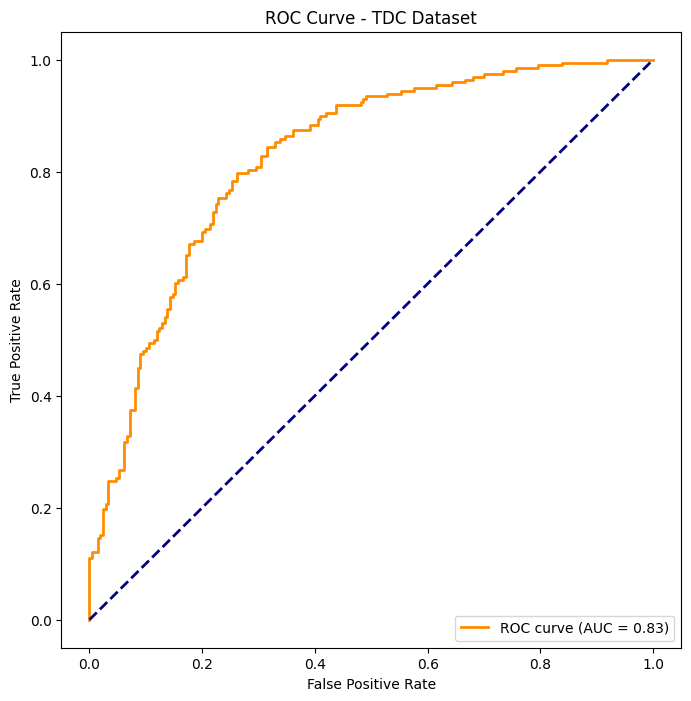

In [17]:
# Predict probabilities for the positive class
tdc_predictions_proba = AutoML_model.predict_proba(X_tdc)[:, 1]

# Assuming you have the true labels in 'Target' column
# Calculate ROC curve and AUC
fpr_tdc, tpr_tdc, thresholds_tdc = roc_curve(tdc_data['Y'], tdc_predictions_proba)
auc_tdc = auc(fpr_tdc, tpr_tdc)

print(f"AUC on TDC dataset: {auc_tdc}")

# Optionally, visualize the ROC curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.plot(fpr_tdc, tpr_tdc, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_tdc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - TDC Dataset')
plt.legend(loc="lower right")
plt.show()

In [18]:
from sklearn.metrics import classification_report

# Assuming you have true labels in 'Y' column
true_labels = tdc_data['Y']

# Set a threshold for binary classification (if needed)
threshold = 0.5  # Adjust this threshold based on your specific requirements

# Assuming you have predictions in 'tdc_predictions_proba'
tdc_predictions = (tdc_predictions_proba > threshold).astype(int)

# Generate classification report
classification_rep = classification_report(true_labels, tdc_predictions)

# Print the classification report
print("Classification Report on TDC dataset:")
print(classification_rep)

Classification Report on TDC dataset:
              precision    recall  f1-score   support

         0.0       0.92      0.29      0.44       210
         1.0       0.56      0.97      0.71       198

    accuracy                           0.62       408
   macro avg       0.74      0.63      0.57       408
weighted avg       0.75      0.62      0.57       408



In [19]:
from sklearn.metrics import confusion_matrix

# Assuming you have true labels in 'Y' column
true_labels = tdc_data['Y']

# Set a threshold for binary classification (if needed)
threshold = 0.5  # Adjust this threshold based on your specific requirements

# Assuming you have predictions in 'tdc_predictions_proba'
tdc_predictions = (tdc_predictions_proba > threshold).astype(int)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, tdc_predictions)

# Print the confusion matrix
print("Confusion Matrix on TDC dataset:")
print(conf_matrix)


Confusion Matrix on TDC dataset:
[[ 60 150]
 [  5 193]]


In [ ]:
## AutoML with morgan fingerprints

In [48]:
# Load the model
model_path = '../../checkpoints/AutoML_morgan_fp.joblib'
AutoML_model = joblib.load(model_path)

In [49]:
# Load the TDC dataset
tdc_data_path = '../data/filtered_tdc_dataset.csv'
tdc_data = pd.read_csv(tdc_data_path)

In [50]:
# Add RDKit Molecules Column and Filter out Invalid Molecules
tdc_data['mol'] = tdc_data['Drug'].apply(lambda x: Chem.MolFromSmiles(x) if x is not None else None)
tdc_data = tdc_data.dropna(subset=['mol'])

# Generate Morgan Fingerprints
tdc_data['morgan_fps'] = tdc_data['mol'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=1024))

In [51]:
# Prepare Data for Model Input
max_length = max(len(fp.GetOnBits()) for fp in tdc_data['morgan_fps'])
X_tdc = np.array([list(fp.GetOnBits()) + [0] * (max_length - len(fp.GetOnBits())) for fp in tdc_data['morgan_fps']])

In [52]:
# Assuming X_tdc is your TDC dataset with 95 features
X_tdc = np.hstack([X_tdc, np.zeros((X_tdc.shape[0], 123 - 95))])

In [53]:
X_tdc.shape

(408, 123)

In [54]:
y_tdc = tdc_data['Y']

AUC on TDC dataset: 0.6221861471861472


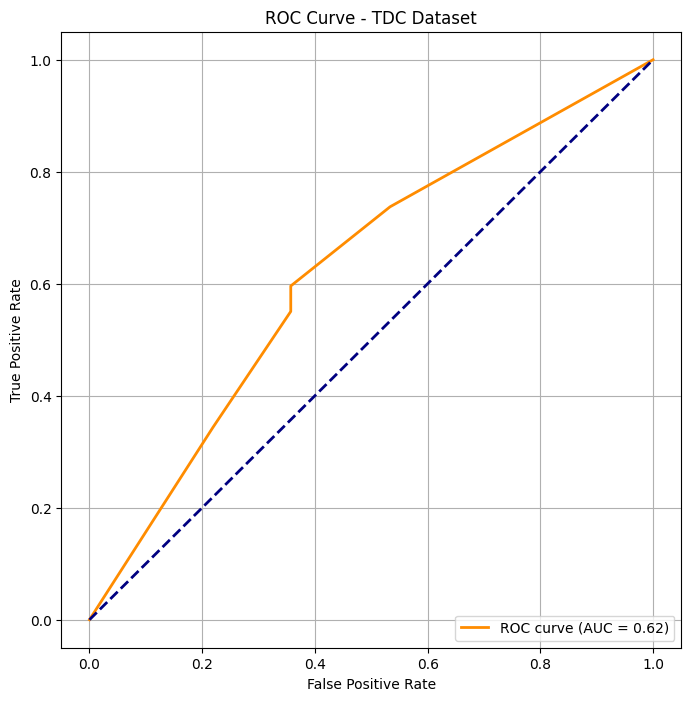

In [55]:
# Predict probabilities for the positive class
tdc_predictions_proba = AutoML_model.predict_proba(X_tdc)[:, 1]

# Calculate ROC curve and AUC
fpr_tdc, tpr_tdc, thresholds_tdc = roc_curve(y_tdc, tdc_predictions_proba)
auc_tdc = auc(fpr_tdc, tpr_tdc)

print(f"AUC on TDC dataset: {auc_tdc}")

#  visualize the ROC curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.plot(fpr_tdc, tpr_tdc, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_tdc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - TDC Dataset')
plt.legend(loc="lower right")
plt.grid(True)  
plt.show()

In [56]:
from sklearn.metrics import classification_report

# Assuming you have true labels in 'Y' column
true_labels = tdc_data['Y']

# Set a threshold for binary classification (if needed)
threshold = 0.5  # Adjust this threshold based on your specific requirements

# Assuming you have predictions in 'tdc_predictions_proba'
tdc_predictions = (tdc_predictions_proba > threshold).astype(int)

# Generate classification report
classification_rep = classification_report(true_labels, tdc_predictions)

# Print the classification report
print("Classification Report on TDC dataset:")
print(classification_rep)

Classification Report on TDC dataset:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       210
         1.0       0.49      1.00      0.65       198

    accuracy                           0.49       408
   macro avg       0.24      0.50      0.33       408
weighted avg       0.24      0.49      0.32       408



/home/leila/miniconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leila/miniconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leila/miniconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [57]:
from sklearn.metrics import confusion_matrix

# Assuming you have true labels in 'Y' column
true_labels = tdc_data['Y']

# Set a threshold for binary classification (if needed)
threshold = 0.5  # Adjust this threshold based on your specific requirements

# Assuming you have predictions in 'tdc_predictions_proba'
tdc_predictions = (tdc_predictions_proba > threshold).astype(int)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, tdc_predictions)

# Print the confusion matrix
print("Confusion Matrix on TDC dataset:")
print(conf_matrix)


Confusion Matrix on TDC dataset:
[[  0 210]
 [  0 198]]


In [ ]:
## Autogluon with Morgan fingerprints

In [ ]:
# Load the model
model_path = '../AutogluonModels/'
AutoML_model = joblib.load(model_path)

In [58]:
# Load the TDC dataset
tdc_data_path = '../data/filtered_tdc_dataset.csv'
tdc_data = pd.read_csv(tdc_data_path)

In [60]:
import pandas as pd
from rdkit.Chem import AllChem, MolFromSmiles

tdc_data['mol'] = tdc_data['Drug'].apply(lambda x: MolFromSmiles(x))
# Generate Morgan fingerprints
tdc_data['morgan_fp'] = tdc_data['mol'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=1024))
# Convert Morgan fingerprints to a binary vector representation
tdc_data['morgan_vec'] = [list(fp.ToBitString()) for fp in tdc_data['morgan_fp']]

In [61]:
# Assuming 'morgan_vec' is the column containing binary vector representations
X_tdc = tdc_data['morgan_vec'].tolist()
y_tdc = tdc_data['Y']

In [67]:
from autogluon.tabular import TabularPredictor
predictor = TabularPredictor.load("AutogluonModels/ag-20240113_234140")

In [68]:
tdc_predictions = predictor.predict(tdc_data)

KeyError: "1060 required columns are missing from the provided dataset to transform using AutoMLPipelineFeatureGenerator. 1060 missing columns: ['nAcid', 'naAromAtom', 'nAromBond', 'nN', 'nO', 'nS', 'nP', 'nF', 'nCl', 'nBr', 'nI', 'nX', 'nBase', 'nBondsD', 'nBondsD2', 'nBondsT', 'C1SP1', 'C2SP1', 'C1SP2', 'C2SP2', 'C3SP2', 'C1SP3', 'C2SP3', 'C3SP3', 'C4SP3', 'nHBd', 'nwHBd', 'nHBint2', 'nHBint3', 'nHBint4', 'nHBint5', 'nHBint6', 'nHBint7', 'nHBint9', 'nHBint10', 'nHsOH', 'nHdNH', 'nHsSH', 'nHsNH2', 'nHssNH', 'nHaaNH', 'nHsNH3p', 'nHtCH', 'nHdCH2', 'nHaaCH', 'nHCsatu', 'nHAvin', 'nHother', 'nddC', 'ntsC', 'ndssC', 'naasC', 'naaaC', 'nssssC', 'ntN', 'ndsN', 'naaN', 'nsssN', 'naasN', 'nssssNp', 'ndO', 'nssO', 'naaO', 'nsOm', 'ndS', 'nssS', 'naaS', 'ndssS', 'nddssS', 'nHBAcc', 'nHBAcc3', 'nHBDon', 'nHBDon_Lipinski', 'nAtomLAC', 'nRing', 'n3Ring', 'n4Ring', 'n5Ring', 'n6Ring', 'n7Ring', 'n8Ring', 'n9Ring', 'n11Ring', 'n12Ring', 'nG12Ring', 'nFRing', 'nF6Ring', 'nF7Ring', 'nF8Ring', 'nF9Ring', 'nF10Ring', 'nF11Ring', 'nF12Ring', 'nFG12Ring', 'nTRing', 'nT6Ring', 'nT7Ring', 'nT8Ring', 'nT9Ring', 'nT11Ring', 'nT12Ring', 'nTG12Ring', 'nHeteroRing', 'n3HeteroRing', 'n5HeteroRing', 'n6HeteroRing', 'n7HeteroRing', 'nF6HeteroRing', 'nF7HeteroRing', 'nF8HeteroRing', 'nF9HeteroRing', 'nF10HeteroRing', 'nF11HeteroRing', 'nF12HeteroRing', 'nFG12HeteroRing', 'nT6HeteroRing', 'nT7HeteroRing', 'nT9HeteroRing', 'nT11HeteroRing', 'nT12HeteroRing', 'nTG12HeteroRing', 'LipinskiFailures', 'topoRadius', 'ALogP', 'ALogp2', 'AMR', 'apol', 'nAtom', 'nHeavyAtom', 'nH', 'nC', 'ATS0m', 'ATS1m', 'ATS2m', 'ATS3m', 'ATS4m', 'ATS5m', 'ATS6m', 'ATS7m', 'ATS8m', 'ATS0v', 'ATS1v', 'ATS2v', 'ATS3v', 'ATS4v', 'ATS5v', 'ATS6v', 'ATS7v', 'ATS8v', 'ATS0e', 'ATS1e', 'ATS2e', 'ATS3e', 'ATS4e', 'ATS5e', 'ATS6e', 'ATS7e', 'ATS8e', 'ATS0p', 'ATS1p', 'ATS2p', 'ATS3p', 'ATS4p', 'ATS5p', 'ATS6p', 'ATS7p', 'ATS8p', 'ATS0i', 'ATS1i', 'ATS2i', 'ATS3i', 'ATS4i', 'ATS5i', 'ATS6i', 'ATS7i', 'ATS8i', 'ATS0s', 'ATS1s', 'ATS2s', 'ATS3s', 'ATS4s', 'ATS5s', 'ATS6s', 'ATS7s', 'ATS8s', 'AATS0m', 'AATS1m', 'AATS2m', 'AATS3m', 'AATS4m', 'AATS5m', 'AATS6m', 'AATS7m', 'AATS8m', 'AATS0v', 'AATS1v', 'AATS2v', 'AATS3v', 'AATS4v', 'AATS5v', 'AATS6v', 'AATS7v', 'AATS8v', 'AATS0e', 'AATS1e', 'AATS2e', 'AATS3e', 'AATS4e', 'AATS5e', 'AATS6e', 'AATS7e', 'AATS8e', 'AATS0p', 'AATS1p', 'AATS2p', 'AATS3p', 'AATS4p', 'AATS5p', 'AATS6p', 'AATS7p', 'AATS8p', 'AATS0i', 'AATS1i', 'AATS2i', 'AATS3i', 'AATS4i', 'AATS5i', 'AATS6i', 'AATS7i', 'AATS8i', 'AATS0s', 'AATS1s', 'AATS2s', 'AATS3s', 'AATS4s', 'AATS5s', 'AATS6s', 'AATS7s', 'AATS8s', 'ATSC0c', 'ATSC1c', 'ATSC2c', 'ATSC3c', 'ATSC4c', 'ATSC5c', 'ATSC6c', 'ATSC7c', 'ATSC8c', 'ATSC0m', 'ATSC1m', 'ATSC2m', 'ATSC3m', 'ATSC4m', 'ATSC5m', 'ATSC6m', 'ATSC7m', 'ATSC8m', 'ATSC0v', 'ATSC1v', 'ATSC2v', 'ATSC3v', 'ATSC4v', 'ATSC5v', 'ATSC6v', 'ATSC7v', 'ATSC8v', 'ATSC0e', 'ATSC1e', 'ATSC2e', 'ATSC3e', 'ATSC4e', 'ATSC5e', 'ATSC6e', 'ATSC7e', 'ATSC8e', 'ATSC0p', 'ATSC1p', 'ATSC2p', 'ATSC3p', 'ATSC4p', 'ATSC5p', 'ATSC6p', 'ATSC7p', 'ATSC8p', 'ATSC0i', 'ATSC1i', 'ATSC2i', 'ATSC3i', 'ATSC4i', 'ATSC5i', 'ATSC6i', 'ATSC7i', 'ATSC8i', 'ATSC0s', 'ATSC1s', 'ATSC2s', 'ATSC3s', 'ATSC4s', 'ATSC5s', 'ATSC6s', 'ATSC7s', 'ATSC8s', 'AATSC0c', 'AATSC1c', 'AATSC2c', 'AATSC3c', 'AATSC4c', 'AATSC5c', 'AATSC6c', 'AATSC7c', 'AATSC8c', 'AATSC0m', 'AATSC1m', 'AATSC2m', 'AATSC3m', 'AATSC4m', 'AATSC5m', 'AATSC6m', 'AATSC7m', 'AATSC8m', 'AATSC0v', 'AATSC1v', 'AATSC2v', 'AATSC3v', 'AATSC4v', 'AATSC5v', 'AATSC6v', 'AATSC7v', 'AATSC8v', 'AATSC0e', 'AATSC1e', 'AATSC2e', 'AATSC3e', 'AATSC4e', 'AATSC5e', 'AATSC6e', 'AATSC7e', 'AATSC8e', 'AATSC0p', 'AATSC1p', 'AATSC2p', 'AATSC3p', 'AATSC4p', 'AATSC5p', 'AATSC6p', 'AATSC7p', 'AATSC8p', 'AATSC0i', 'AATSC1i', 'AATSC2i', 'AATSC3i', 'AATSC4i', 'AATSC5i', 'AATSC6i', 'AATSC7i', 'AATSC8i', 'AATSC0s', 'AATSC1s', 'AATSC2s', 'AATSC3s', 'AATSC4s', 'AATSC5s', 'AATSC6s', 'AATSC7s', 'AATSC8s', 'MATS1c', 'MATS2c', 'MATS3c', 'MATS4c', 'MATS5c', 'MATS6c', 'MATS7c', 'MATS8c', 'MATS1m', 'MATS2m', 'MATS3m', 'MATS4m', 'MATS5m', 'MATS6m', 'MATS7m', 'MATS8m', 'MATS1v', 'MATS2v', 'MATS3v', 'MATS4v', 'MATS5v', 'MATS6v', 'MATS7v', 'MATS8v', 'MATS1e', 'MATS2e', 'MATS3e', 'MATS4e', 'MATS5e', 'MATS6e', 'MATS7e', 'MATS8e', 'MATS1p', 'MATS2p', 'MATS3p', 'MATS4p', 'MATS5p', 'MATS6p', 'MATS7p', 'MATS8p', 'MATS1i', 'MATS2i', 'MATS3i', 'MATS4i', 'MATS5i', 'MATS6i', 'MATS7i', 'MATS8i', 'MATS1s', 'MATS2s', 'MATS3s', 'MATS4s', 'MATS5s', 'MATS6s', 'MATS7s', 'MATS8s', 'GATS1c', 'GATS2c', 'GATS3c', 'GATS4c', 'GATS5c', 'GATS6c', 'GATS7c', 'GATS8c', 'GATS1m', 'GATS2m', 'GATS3m', 'GATS4m', 'GATS5m', 'GATS6m', 'GATS7m', 'GATS8m', 'GATS1v', 'GATS2v', 'GATS3v', 'GATS4v', 'GATS5v', 'GATS6v', 'GATS7v', 'GATS8v', 'GATS1e', 'GATS2e', 'GATS3e', 'GATS4e', 'GATS5e', 'GATS6e', 'GATS7e', 'GATS8e', 'GATS1p', 'GATS2p', 'GATS3p', 'GATS4p', 'GATS5p', 'GATS6p', 'GATS7p', 'GATS8p', 'GATS1i', 'GATS2i', 'GATS3i', 'GATS4i', 'GATS5i', 'GATS6i', 'GATS7i', 'GATS8i', 'GATS1s', 'GATS2s', 'GATS3s', 'GATS4s', 'GATS5s', 'GATS6s', 'GATS7s', 'GATS8s', 'SpAbs_DzZ', 'EE_DzZ', 'SM1_DzZ', 'VE1_DzZ', 'VE2_DzZ', 'SM1_Dzm', 'VE1_Dzm', 'VE2_Dzm', 'VE3_Dzm', 'EE_Dzv', 'SM1_Dzv', 'VE1_Dzv', 'VE2_Dzv', 'VE1_Dze', 'VE2_Dze', 'VE3_Dze', 'EE_Dzp', 'VE1_Dzp', 'VE2_Dzp', 'VE1_Dzi', 'VE2_Dzi', 'VE3_Dzi', 'SpAbs_Dzs', 'EE_Dzs', 'SM1_Dzs', 'VE1_Dzs', 'VE2_Dzs', 'VE3_Dzs', 'nBonds', 'nBonds2', 'nBondsS', 'nBondsS2', 'nBondsS3', 'nBondsM', 'bpol', 'SpMax1_Bhm', 'SpMax2_Bhm', 'SpMax3_Bhm', 'SpMax4_Bhm', 'SpMax5_Bhm', 'SpMax6_Bhm', 'SpMax7_Bhm', 'SpMax8_Bhm', 'SpMin1_Bhm', 'SpMin2_Bhm', 'SpMin3_Bhm', 'SpMin4_Bhm', 'SpMin5_Bhm', 'SpMin6_Bhm', 'SpMin7_Bhm', 'SpMin8_Bhm', 'SpMax2_Bhv', 'SpMax3_Bhv', 'SpMax4_Bhv', 'SpMax5_Bhv', 'SpMax6_Bhv', 'SpMax7_Bhv', 'SpMax8_Bhv', 'SpMin2_Bhv', 'SpMin3_Bhv', 'SpMin4_Bhv', 'SpMin5_Bhv', 'SpMin6_Bhv', 'SpMin7_Bhv', 'SpMin8_Bhv', 'SpMax2_Bhe', 'SpMax3_Bhe', 'SpMax4_Bhe', 'SpMax5_Bhe', 'SpMax6_Bhe', 'SpMax7_Bhe', 'SpMax8_Bhe', 'SpMin2_Bhe', 'SpMin3_Bhe', 'SpMin4_Bhe', 'SpMin5_Bhe', 'SpMin6_Bhe', 'SpMin7_Bhe', 'SpMin8_Bhe', 'SpMax2_Bhp', 'SpMax3_Bhp', 'SpMax4_Bhp', 'SpMax5_Bhp', 'SpMax6_Bhp', 'SpMax7_Bhp', 'SpMax8_Bhp', 'SpMin2_Bhp', 'SpMin3_Bhp', 'SpMin4_Bhp', 'SpMin5_Bhp', 'SpMin6_Bhp', 'SpMin7_Bhp', 'SpMin8_Bhp', 'SpMax2_Bhi', 'SpMax3_Bhi', 'SpMax4_Bhi', 'SpMax5_Bhi', 'SpMax6_Bhi', 'SpMax7_Bhi', 'SpMax8_Bhi', 'SpMin2_Bhi', 'SpMin3_Bhi', 'SpMin4_Bhi', 'SpMin5_Bhi', 'SpMin6_Bhi', 'SpMin7_Bhi', 'SpMin8_Bhi', 'SpMax3_Bhs', 'SpMax4_Bhs', 'SpMax5_Bhs', 'SpMax6_Bhs', 'SpMax7_Bhs', 'SpMax8_Bhs', 'SpMin3_Bhs', 'SpMin4_Bhs', 'SpMin5_Bhs', 'SpMin6_Bhs', 'SpMin7_Bhs', 'SpMin8_Bhs', 'SCH3', 'SCH4', 'SCH5', 'SCH6', 'SCH7', 'VCH3', 'VCH4', 'VCH5', 'VCH6', 'VCH7', 'SC3', 'SC4', 'SC5', 'SC6', 'VC3', 'VC4', 'VC5', 'VC6', 'SPC4', 'SPC5', 'SPC6', 'VPC4', 'VPC5', 'VPC6', 'SP0', 'SP1', 'SP2', 'SP3', 'SP4', 'SP5', 'SP6', 'SP7', 'ASP0', 'ASP1', 'ASP2', 'ASP3', 'ASP4', 'ASP5', 'ASP6', 'ASP7', 'VP0', 'VP1', 'VP3', 'VP4', 'VP5', 'VP6', 'VP7', 'AVP6', 'Sv', 'Sse', 'Spe', 'Sare', 'Sp', 'Si', 'Mv', 'Mse', 'Mpe', 'Mare', 'Mp', 'Mi', 'CrippenLogP', 'CrippenMR', 'SpMax_Dt', 'SpDiam_Dt', 'SpAD_Dt', 'SpMAD_Dt', 'EE_Dt', 'VE1_Dt', 'VE2_Dt', 'VE3_Dt', 'VR1_Dt', 'VR2_Dt', 'VR3_Dt', 'ECCEN', 'nHBa', 'nwHBa', 'nHBint8', 'nHCsats', 'SHBd', 'SwHBd', 'SHBa', 'SwHBa', 'SHBint2', 'SHBint3', 'SHBint4', 'SHBint5', 'SHBint6', 'SHBint7', 'SHBint8', 'SHBint9', 'SHBint10', 'SHsOH', 'SHdNH', 'SHsSH', 'SHsNH2', 'SHssNH', 'SHaaNH', 'SHtCH', 'SHdCH2', 'SHaaCH', 'SHCsats', 'SHCsatu', 'SHAvin', 'SHother', 'SsCH3', 'SdCH2', 'SssCH2', 'StCH', 'SaaCH', 'StsC', 'SdssC', 'SaasC', 'SaaaC', 'SssssC', 'SsNH2', 'SdNH', 'SssNH', 'SaaNH', 'StN', 'SdsN', 'SaaN', 'SsssN', 'SaasN', 'SssssNp', 'SsOH', 'SdO', 'SssO', 'SaaO', 'SsOm', 'SsF', 'SdsssP', 'SsSH', 'SdS', 'SssS', 'SaaS', 'SdssS', 'SddssS', 'SsCl', 'SsBr', 'SsI', 'minHBd', 'minwHBd', 'minHBa', 'minwHBa', 'minHBint2', 'minHBint3', 'minHBint4', 'minHBint5', 'minHBint6', 'minHBint7', 'minHBint8', 'minHBint9', 'minHBint10', 'minHsOH', 'minHsSH', 'minHsNH2', 'minHssNH', 'minHaaCH', 'minHCsats', 'minHCsatu', 'minHAvin', 'minHother', 'minsCH3', 'minssCH2', 'mindsCH', 'minaaCH', 'mintsC', 'mindssC', 'minaasC', 'minaaaC', 'minssssC', 'minsNH2', 'minssNH', 'mintN', 'mindsN', 'minaaN', 'minsssN', 'minaasN', 'minssssNp', 'minsOH', 'mindO', 'minssO', 'minsOm', 'minsF', 'mindsssP', 'minsSH', 'mindS', 'minssS', 'minaaS', 'minddssS', 'minsCl', 'minsBr', 'minsI', 'maxHBd', 'maxwHBd', 'maxHBa', 'maxwHBa', 'maxHBint2', 'maxHBint3', 'maxHBint4', 'maxHBint5', 'maxHBint6', 'maxHBint7', 'maxHBint8', 'maxHBint9', 'maxHBint10', 'maxHsOH', 'maxHsSH', 'maxHsNH2', 'maxHssNH', 'maxHaaCH', 'maxHCsats', 'maxHCsatu', 'maxHother', 'maxsCH3', 'maxssCH2', 'maxaaCH', 'maxtsC', 'maxdssC', 'maxaasC', 'maxaaaC', 'maxssssC', 'maxsNH2', 'maxssNH', 'maxdsN', 'maxaaN', 'maxsssN', 'maxsOH', 'maxdO', 'maxssO', 'maxsOm', 'maxsF', 'maxsSH', 'maxsCl', 'maxsBr', 'sumI', 'meanI', 'hmax', 'gmax', 'hmin', 'gmin', 'LipoaffinityIndex', 'MAXDN', 'MAXDP', 'DELS', 'MAXDN2', 'MAXDP2', 'DELS2', 'ETA_Alpha', 'ETA_AlphaP', 'ETA_dAlpha_A', 'ETA_dAlpha_B', 'ETA_Epsilon_1', 'ETA_Epsilon_2', 'ETA_Epsilon_3', 'ETA_Epsilon_4', 'ETA_Epsilon_5', 'ETA_dEpsilon_A', 'ETA_dEpsilon_B', 'ETA_dEpsilon_C', 'ETA_dEpsilon_D', 'ETA_Psi_1', 'ETA_dPsi_A', 'ETA_dPsi_B', 'ETA_Shape_P', 'ETA_Shape_Y', 'ETA_Shape_X', 'ETA_Beta', 'ETA_BetaP', 'ETA_Beta_s', 'ETA_BetaP_s', 'ETA_Beta_ns', 'ETA_BetaP_ns', 'ETA_dBeta', 'ETA_dBetaP', 'ETA_Beta_ns_d', 'ETA_BetaP_ns_d', 'ETA_Eta', 'ETA_EtaP', 'ETA_Eta_R', 'ETA_Eta_F', 'ETA_EtaP_F', 'ETA_Eta_L', 'ETA_EtaP_L', 'ETA_Eta_R_L', 'ETA_Eta_F_L', 'ETA_EtaP_F_L', 'ETA_Eta_B', 'ETA_EtaP_B', 'ETA_Eta_B_RC', 'ETA_EtaP_B_RC', 'FMF', 'fragC', 'nHBAcc2', 'nHBAcc_Lipinski', 'HybRatio', 'IC0', 'IC1', 'IC2', 'IC3', 'IC4', 'IC5', 'TIC0', 'TIC1', 'TIC2', 'TIC3', 'TIC4', 'TIC5', 'SIC0', 'SIC1', 'SIC2', 'SIC3', 'SIC4', 'SIC5', 'CIC0', 'CIC1', 'CIC2', 'CIC3', 'CIC4', 'CIC5', 'BIC0', 'BIC1', 'BIC2', 'BIC3', 'BIC4', 'BIC5', 'MIC0', 'MIC1', 'MIC2', 'MIC3', 'MIC4', 'MIC5', 'ZMIC0', 'ZMIC1', 'ZMIC2', 'ZMIC3', 'ZMIC4', 'ZMIC5', 'Kier1', 'Kier2', 'Kier3', 'nAtomLC', 'nAtomP', 'MLogP', 'McGowan_Volume', 'MDEC11', 'MDEC12', 'MDEC13', 'MDEC14', 'MDEC22', 'MDEC23', 'MDEC24', 'MDEC33', 'MDEC34', 'MDEC44', 'MDEO11', 'MDEO12', 'MDEO22', 'MDEN11', 'MDEN12', 'MDEN13', 'MDEN22', 'MDEN23', 'MDEN33', 'MLFER_A', 'MLFER_BH', 'MLFER_BO', 'MLFER_S', 'MLFER_E', 'MLFER_L', 'MPC2', 'MPC3', 'MPC4', 'MPC5', 'MPC6', 'MPC7', 'MPC8', 'MPC9', 'MPC10', 'TPC', 'piPC1', 'piPC2', 'piPC3', 'piPC4', 'piPC5', 'piPC6', 'piPC7', 'piPC8', 'piPC9', 'piPC10', 'TpiPC', 'R_TpiPCTPC', 'PetitjeanNumber', 'nRotB', 'RotBFrac', 'nRotBt', 'RotBtFrac', 'topoDiameter', 'topoShape', 'GGI1', 'GGI2', 'GGI3', 'GGI4', 'GGI5', 'GGI6', 'GGI7', 'GGI8', 'GGI9', 'GGI10', 'JGI1', 'JGI2', 'JGI3', 'JGI4', 'JGI5', 'JGI6', 'JGI7', 'JGI8', 'JGI9', 'JGI10', 'JGT', 'SpMax_D', 'SpDiam_D', 'SpAD_D', 'SpMAD_D', 'EE_D', 'VE1_D', 'VE2_D', 'VE3_D', 'VR1_D', 'VR2_D', 'VR3_D', 'TopoPSA', 'VABC', 'VAdjMat', 'MWC2', 'MWC3', 'MWC4', 'MWC5', 'MWC6', 'MWC7', 'MWC8', 'MWC9', 'MWC10', 'TWC', 'SRW2', 'SRW4', 'SRW5', 'SRW6', 'SRW7', 'SRW8', 'SRW9', 'SRW10', 'TSRW', 'MW', 'AMW', 'WTPT1', 'WTPT2', 'WTPT3', 'WTPT4', 'WTPT5', 'WPATH', 'WPOL', 'XLogP', 'Zagreb'] | 6 available columns: ['Drug_ID', 'Drug', 'Y', 'mol', 'morgan_fp', 'morgan_vec']"

In [ ]:
## Autogluon with ersilia embeddings